In [1]:
import pandas as pd
import time
from finta import TA
import numpy as np
import pandas as pd
import datetime as dt
import copy
import json
from py5paisa import FivePaisaClient

client = FivePaisaClient(email="sudhanshu8833@gmail.com", passwd="Madhya246###", dob="20010626")
client.login()


 12:51:34 | Logged in!!


In [2]:
tickers={"7":"AARTIIND","100":"AMARAJABAT"}

In [3]:
ohlc_intraday={}

In [4]:
for ticker in tickers:
    ohlc_intraday[ticker]=client.historical_data('N','C',int(ticker),'1m','2021-01-25','2021-06-16')
    print("got data for:",tickers[ticker])

got data for: AARTIIND
got data for: AMARAJABAT


In [5]:
ohlc_intraday

{'7':                   Datetime     Open     High      Low    Close  Volume
 0      2021-01-25T09:15:00  1154.00  1161.30  1150.70  1158.80    3428
 1      2021-01-25T09:16:00  1158.80  1159.20  1155.00  1158.20     854
 2      2021-01-25T09:17:00  1157.55  1158.60  1157.00  1157.00    2980
 3      2021-01-25T09:18:00  1157.00  1157.40  1155.00  1155.05    2252
 4      2021-01-25T09:19:00  1155.05  1156.15  1153.35  1153.35    2076
 ...                    ...      ...      ...      ...      ...     ...
 35692  2021-06-16T15:25:00  1827.15  1827.50  1825.00  1825.00    1791
 35693  2021-06-16T15:26:00  1825.40  1826.15  1825.00  1825.35     571
 35694  2021-06-16T15:27:00  1825.35  1826.00  1824.15  1824.15    1825
 35695  2021-06-16T15:28:00  1824.15  1824.20  1823.60  1823.60    1456
 35696  2021-06-16T15:29:00  1823.60  1830.00  1822.05  1830.00    3061
 
 [35697 rows x 6 columns],
 '100':                   Datetime    Open    High     Low   Close  Volume
 0      2021-01-25T09:15:00

In [6]:
ohlc_dict=copy.deepcopy(ohlc_intraday)

In [7]:
def MACD(DF,a,b,c):
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    df = DF.copy()
    df["MA_Fast"]=df["close"].ewm(span=a,min_periods=a).mean()
    df["MA_Slow"]=df["close"].ewm(span=b,min_periods=b).mean()
    df["MACD"]=df["MA_Fast"]-df["MA_Slow"]
    df["Signal"]=df["MACD"].ewm(span=c,min_periods=c).mean()
    df.dropna(inplace=True)
    df.drop(["MA_Fast","MA_Slow"],axis=1)
    return df


def CAGR(DF):
    "function to calculate the Cumulative Annual Growth Rate of a trading strategy"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    n = len(df)/(252*74)
    CAGR = (df["cum_return"].tolist()[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    "function to calculate annualized volatility of a trading strategy"
    df = DF.copy()
    vol = df["ret"].std() * np.sqrt(252*74)
    return vol

def sharpe(DF,rf):
    "function to calculate sharpe ratio ; rf is the risk free rate"
    df = DF.copy()
    sr = (CAGR(df) - rf)/volatility(df)
    return sr
    

def max_dd(DF):
    "function to calculate max drawdown"
    df = DF.copy()
    df["cum_return"] = (1 + df["ret"]).cumprod()
    df["cum_roll_max"] = df["cum_return"].cummax()
    df["drawdown"] = df["cum_roll_max"] - df["cum_return"]
    df["drawdown_pct"] = df["drawdown"]/df["cum_roll_max"]
    max_dd = df["drawdown_pct"].max()
    return max_dd

def win_pct(DF):
    df=DF.copy()
    j=0
    for i in range(len(df)):
        if df["profit"][i]>0:
            j+=1

    win_percent=j/len(df)*100

    return win_percent
            


In [8]:
tickers_signal = {}
ticker_ret = {}

In [9]:
for ticker in tickers:
    # ohlc_dict[ticker]=ohlc_dict[ticker].iloc[:,[0,1,2,4,5]]
    ohlc_dict[ticker].set_index('Datetime',inplace=True)
    ohlc_dict[ticker].columns=["open","high","low","close","volume"]
    ohlc_dict[ticker]["fisher 20"]=TA.FISH(ohlc_dict[ticker],20)
    ohlc_dict[ticker]["fisher 10"]=TA.FISH(ohlc_dict[ticker],10)    
    ohlc_dict[ticker]["RSI 16"]=TA.RSI(ohlc_dict[ticker],16)
    ohlc_dict[ticker]["RSI 21"]=TA.RSI(ohlc_dict[ticker],21)
    ohlc_dict[ticker]["MACD macd line"]=MACD(ohlc_dict[ticker],12,26,9)["MACD"]
    ohlc_dict[ticker]["MACD signal line"]=MACD(ohlc_dict[ticker],12,26,9)["Signal"]
    
    ohlc_dict[ticker].dropna(inplace=True)
    

In [10]:
ohlc_dict["7"]

,open,high,low,close,volume,fisher 20,fisher 10,RSI 16,RSI 21,MACD macd line,MACD signal line
Datetime,,,,,,,,,,,
2021-01-25T09:48:00,1126.05,1128.80,1126.05,1128.80,1107,-6.421774,-5.100552,17.586523,18.468138,-5.503775,-4.472254
2021-01-25T09:49:00,1128.80,1130.85,1126.95,1130.20,831,-4.987747,-4.074584,22.094631,22.278347,-5.515627,-4.706030
2021-01-25T09:50:00,1130.80,1134.65,1130.15,1134.65,1410,-3.681433,-2.829397,34.282737,32.765025,-5.126749,-4.798081
2021-01-25T09:51:00,1130.95,1138.45,1130.95,1138.35,950,-2.702889,-1.685135,42.290101,39.850354,-4.484059,-4.730642
2021-01-25T09:52:00,1136.55,1138.45,1135.05,1136.20,1035,-1.982954,-0.683934,39.320522,37.442888,-4.092666,-4.595624
...,...,...,...,...,...,...,...,...,...,...,...
2021-06-16T15:25:00,1827.15,1827.50,1825.00,1825.00,1791,-2.765448,-1.628423,38.559327,39.344778,-1.663423,-1.708922
2021-06-16T15:26:00,1825.40,1826.15,1825.00,1825.35,571,-2.887684,-1.717573,39.787434,40.284616,-1.652768,-1.697691
2021-06-16T15:27:00,1825.35,1826.00,1824.15,1824.15,1825,-3.159684,-1.991523,37.077069,38.156219,-1.721312,-1.702416


In [11]:
ticker_signal={}
ticker_ret={}
ohlc_database={}
price_in=[]
price_out=[]
order=[]
stock=[]


In [12]:
for ticker in tickers:
    ticker_signal[ticker]=[]
    ticker_ret[ticker]=[]
    ohlc_database[ticker]=pd.DataFrame()

    ohlc_dict[ticker].rename(columns={"open":"Open","high":"High","low":"Low","close":"Close","volume":"Volume"},inplace=True)
    
for ticker in tickers:
    signal=""
    for i in range(len(ohlc_dict[ticker])):
        if signal=="":
            if ohlc_dict[ticker]["fisher 10"][i]>0 and ohlc_dict[ticker]["fisher 10"][i-1]<0 and ohlc_dict[ticker]["RSI 16"][i]>50: 
                signal="buy"
                price=ohlc_dict[ticker]["Close"][i]
                price_in.append(ohlc_dict[ticker]["Close"][i])
                
                order.append("long")
                stock.append(ticker)

                
               



            elif (ohlc_dict[ticker]["fisher 20"][i]<0 and ohlc_dict[ticker]["fisher 20"][i-1]>0) and ohlc_dict[ticker]["MACD macd line"][i]<ohlc_dict[ticker]["MACD signal line"][i] and ohlc_dict[ticker]["RSI 21"][i]<42.5:
                signal="sell"
                price=ohlc_dict[ticker]["Close"][i]
                
                price_in.append(ohlc_dict[ticker]["Close"][i])
                
                order.append("short")
                stock.append(ticker)                
            ticker_ret[ticker].append(0)

        elif signal=="buy":
            if (ohlc_dict[ticker]["fisher 20"][i]<0.5 and ohlc_dict[ticker]["fisher 20"][i-1]>0.5) or ohlc_dict[ticker]["Close"][i]>=price+.02*price or ohlc_dict[ticker]["Close"][i]<=price-.008*price:

                signal=""
                price_out.append(ohlc_dict[ticker]["Close"][i])
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)

            
            
            else:
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i]/ohlc_dict[ticker]["Close"][i-1])-1)
           
        
        
        elif signal=="sell":
            if (ohlc_dict[ticker]["fisher 20"][i]>-1 and ohlc_dict[ticker]["fisher 20"][i-1]<-1) or (ohlc_dict[ticker]["fisher 20"][i]>0 and ohlc_dict[ticker]["fisher 20"][i-1]<0) or ohlc_dict[ticker]["Close"][i]<=price +.02*price or ohlc_dict[ticker]["Close"][i]>=price-.005*price:
                price_out.append(ohlc_dict[ticker]["Close"][i])

                signal=""
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)

          
            
            else:
                ticker_ret[ticker].append((ohlc_dict[ticker]["Close"][i-1]/ohlc_dict[ticker]["Close"][i])-1)
    if len(price_in)!=len(price_out):
        price_out.append(ohlc_dict[ticker]["Close"][-1])
    ohlc_dict[ticker]["ret"] = np.array(ticker_ret[ticker])    

In [13]:
ohlcv_database=pd.DataFrame()

ohlcv_database["price_in"]=np.array(price_in)
ohlcv_database["price_out"]=np.array(price_out)
ohlcv_database["order"]=np.array(order)
ohlcv_database["stock"]=np.array(stock)

In [14]:
profit=[]
for i in range(len(ohlcv_database)):
    if ohlcv_database["order"][i]=="long":
        profit.append(((ohlcv_database["price_out"][i]-ohlcv_database["price_in"][i])/ohlcv_database["price_in"][i])*100)

    elif ohlcv_database["order"][i]=="short":
        profit.append(((ohlcv_database["price_in"][i]-ohlcv_database["price_out"][i])/ohlcv_database["price_out"][i])*100)

ohlcv_database["profit"]=np.array(profit)

In [15]:
ohlcv_database

,price_in,price_out,order,stock,profit
0,1148.70,1138.00,long,7,-0.931488
1,1150.00,1149.70,long,7,-0.026087
2,1150.00,1149.95,long,7,-0.004348
3,1150.95,1155.00,long,7,0.351883
4,1154.95,1156.00,long,7,0.090913
...,...,...,...,...,...
1644,777.00,775.00,long,100,-0.257400
1645,774.50,773.50,short,100,0.129282
1646,775.30,774.25,long,100,-0.135431
1647,775.85,775.80,long,100,-0.006445


In [16]:
strategy_df = pd.DataFrame()
for ticker in tickers:
    strategy_df[ticker] = ohlc_dict[ticker]["ret"]
strategy_df["ret"] = strategy_df.mean(axis=1)
CAGR(strategy_df)



-0.01581131720081863

<AxesSubplot:xlabel='Datetime'>

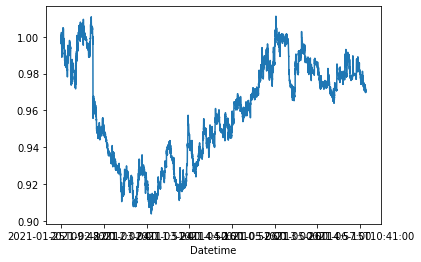

In [17]:
(1+strategy_df["ret"]).cumprod().plot()

In [18]:
cagr = {}
sharpe_ratios = {}
max_drawdown = {}
win_pcts={}
for ticker in tickers:
    win=[]
    print("calculating KPIs for ",ticker)      
    cagr[ticker] =  CAGR(ohlc_dict[ticker])
    for i in range(len(ohlcv_database)):
        if ohlcv_database["stock"][i]==ticker:
            
            win.append(ohlcv_database["profit"][i])
    win_df=pd.DataFrame()
    win_df["profit"]=np.array(win)
    win_pcts[ticker]=win_pct(win_df)           

    sharpe_ratios[ticker] =  sharpe(ohlc_dict[ticker],0.025)
    max_drawdown[ticker] =  max_dd(ohlc_dict[ticker])

KPI_df = pd.DataFrame([cagr,sharpe_ratios,max_drawdown,win_pcts],index=["Return","Sharpe Ratio","Max Drawdown","win_pct"])      
KPI_df.T


calculating KPIs for  7
calculating KPIs for  100


,Return,Sharpe Ratio,Max Drawdown,win_pct
7,0.114782,0.769987,0.121865,38.537794
100,-0.138440,-1.832037,0.266993,31.235154
